# Transfer learning example
    - Cats vs dogs dataset
    - Pretrained keras models
    

In [1]:
from __future__ import print_function

#Basic libraries
import numpy as np
import tensorflow as tf
import time
from os import listdir, walk
from os.path import isfile, join
import random

#Show images
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)        # size of images
plt.rcParams['image.interpolation'] = 'nearest'  # show exact image


# Select GPU
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"


print('Tensorflow version: ', tf.__version__)

data_path = '/home/ubuntu/data/training/image/cats_dogs/'


Tensorflow version:  1.2.1


In [24]:
# Data features
categories=[]
labels={}
for dirname, dirnames, filenames in walk(join(data_path,'train')):
    # print path to all subdirectories first.
    for i,subdirname in enumerate(dirnames):
        categories += [subdirname]
        labels[i] = subdirname
print('Categories: ', categories)

n_classes = len(categories)
print('Num classes: ', n_classes)


Categories:  ['dog', 'cat']
Num classes:  2


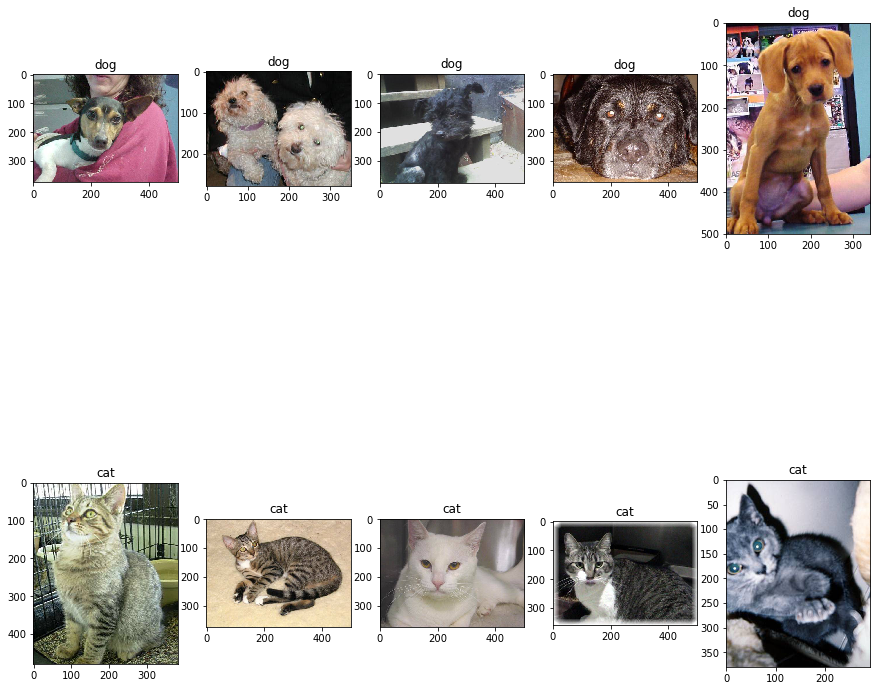

In [25]:
# Examine the images
show_categories = categories
if n_classes>10:
    show_categories = categories[:10]
    
fig = plt.figure()
n=0
for i, category in enumerate(show_categories):
    filelist = [f for f in listdir(join(data_path, 'train', category)) if isfile(join(data_path, 'train', category, f))]
    random.shuffle(filelist) # Randomize images
    for f in filelist[:5]: 
        n += 1
        a = fig.add_subplot(len(show_categories),5,n)
        a.set_title(category)
        img = plt.imread(join(data_path, 'train', category, f))
        plt.imshow(img)
    



## Example: evaluate one image using InceptionV3 imagenet trained model.

In [28]:
from tensorflow.contrib.keras import applications, preprocessing

#Load model
model = applications.inception_v3.InceptionV3(weights='imagenet')


In [29]:
# Lists of image files
my_filelist = [f for f in listdir(join(data_path, 'train', categories[0])) if isfile(join(data_path, 'train', categories[0], f))]


Predicted: [('n02102318', 'cocker_spaniel', 0.94423199), ('n02091831', 'Saluki', 0.0046349377), ('n02099601', 'golden_retriever', 0.0032359255)]


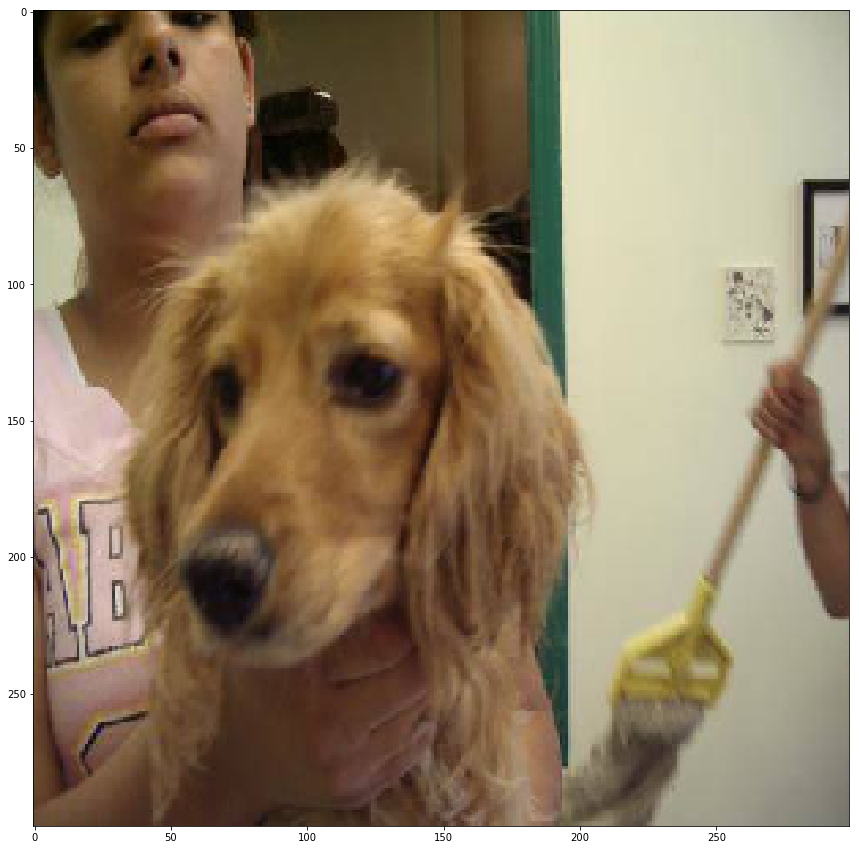

In [30]:
img_path = join(data_path, 'train', categories[0], my_filelist[0])

# Load image and adapt to 
def load_image(img_path, draw=True):
    img = preprocessing.image.load_img(img_path, target_size=(299, 299))
    x = preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = applications.inception_v3.preprocess_input(x)
    if draw:
        plt.imshow(img)
    return x

x = load_image(img_path)
preds = model.predict(x)

# decode the results into a list of tuples (class, description, probability)
print('Predicted:', applications.inception_v3.decode_predictions(preds, top=3)[0])

## Fine tunnig of inceptionV3 for the cats vs dogs problem



In [7]:
from tensorflow.contrib.keras import applications, preprocessing, layers, optimizers, callbacks, models


#Load base model
base_model = applications.inception_v3.InceptionV3(input_shape=(299, 299, 3), weights='imagenet', include_top=False)

# Check the output of the last loaded layer
print('Last layer shape:', base_model.output)

Last layer shape: Tensor("mixed10_3/concat:0", shape=(?, 8, 8, 2048), dtype=float32)


In [8]:
# add a global spatial average pooling layer
x = layers.GlobalAveragePooling2D()(base_model.output)
print('New last layer shape:', x)

# Add a fully-connected layer
#x = layers.Dense(1024, activation='relu')(x)
# Add the prediction layer. 2 classes
predictions = layers.Dense(2, activation='softmax')(x)



New last layer shape: Tensor("global_average_pooling2d/Mean:0", shape=(?, 2048), dtype=float32)


In [9]:
# Model to train
model = models.Model(inputs=base_model.input, outputs=predictions)

# Train only the top layers (which were randomly initialized)
# Freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# Print the summary of the model
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv2d_95 (Conv2D)               (None, 149, 149, 32)  864                                          
____________________________________________________________________________________________________
batch_normalization_95 (BatchNor (None, 149, 149, 32)  96                                           
____________________________________________________________________________________________________
activation_95 (Activation)       (None, 149, 149, 32)  0                                            
___________________________________________________________________________________________

In [10]:
# We preload in memory the original images preprocessed.
datagen = preprocessing.image.ImageDataGenerator()

sample_size_category = 1000
X_all = []
y_all = []
for i,c in enumerate(categories):
    print(join(data_path, 'train', c))
    generator = datagen.flow_from_directory(join(data_path, 'train'), classes=[c],
                                            target_size=(299, 299), batch_size=sample_size_category)
    X, y = next(generator)
    X = applications.inception_v3.preprocess_input(X)
    X_all += list(X)
    y_all += [i]*len(y)

X_all = np.array(X_all)
y_all = np.array(y_all)

print(X_all.shape, y_all.shape)

/home/ubuntu/data/training/image/cats_dogs/train/dog
Found 12500 images belonging to 1 classes.
/home/ubuntu/data/training/image/cats_dogs/train/cat
Found 12500 images belonging to 1 classes.
(2000, 299, 299, 3) (2000,)


In [11]:
# Separate train and valid datasets
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, train_size=0.7)

print(X_train.shape, X_valid.shape)
print(y_train.shape, y_valid.shape)


(1400, 299, 299, 3) (600, 299, 299, 3)
(1400,) (600,)


In [12]:
datagen = preprocessing.image.ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True)
    


In [13]:
batch_size = 32
train_size = X_train.shape[0]

# Select optimizer and compile model
opt = optimizers.RMSprop(lr=1E-3)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Train
tb_callback_ln = callbacks.TensorBoard(log_dir='/tmp/tensorboard/cats_dogs/inception')
history = model.fit_generator(datagen.flow(X_train, y_train),
        steps_per_epoch = train_size // batch_size,
        epochs = 10,
        validation_data = (X_valid, y_valid),
        callbacks=[tb_callback_ln])


Epoch 1/10
43/43 [==============================] - 29s - loss: 0.3976 - acc: 0.8408 - val_loss: 0.1409 - val_acc: 0.9783
Epoch 2/10
43/43 [==============================] - 25s - loss: 0.2034 - acc: 0.9339 - val_loss: 0.1042 - val_acc: 0.9750
Epoch 3/10
43/43 [==============================] - 28s - loss: 0.1489 - acc: 0.9571 - val_loss: 0.0907 - val_acc: 0.9717
Epoch 4/10
43/43 [==============================] - 28s - loss: 0.1291 - acc: 0.9586 - val_loss: 0.0809 - val_acc: 0.9767
Epoch 5/10
43/43 [==============================] - 28s - loss: 0.1090 - acc: 0.9666 - val_loss: 0.0744 - val_acc: 0.9750
Epoch 6/10
43/43 [==============================] - 28s - loss: 0.0975 - acc: 0.9714 - val_loss: 0.1108 - val_acc: 0.9617
Epoch 7/10
43/43 [==============================] - 28s - loss: 0.1093 - acc: 0.9610 - val_loss: 0.0920 - val_acc: 0.9717
Epoch 8/10
43/43 [==============================] - 28s - loss: 0.0816 - acc: 0.9729 - val_loss: 0.0985 - val_acc: 0.9650
Epoch 9/10
43/43 [======

Fists inception cell output shape:  (1, 35, 35, 256)


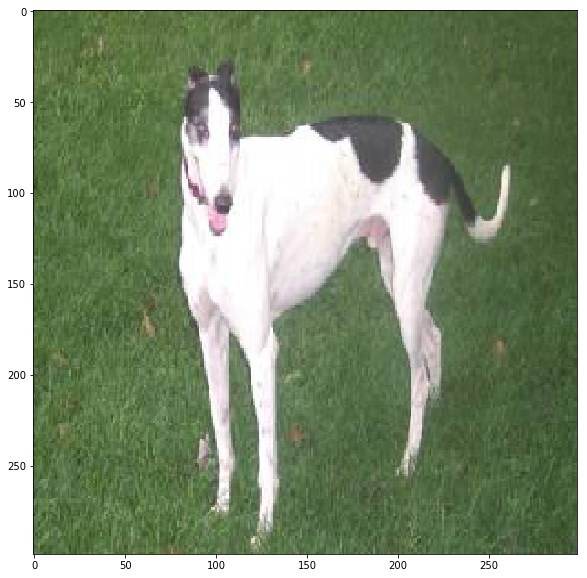

In [14]:
# Print the transformations of the first inception cell: mixed0
model2 = models.Model(inputs=base_model.input, outputs=base_model.get_layer('mixed0').output)

# Read image img
my_filelist = [f for f in listdir(join(data_path, 'train', categories[0])) if isfile(join(data_path, 'train', categories[0], f))]
img_path = join(data_path, 'train', categories[0], my_filelist[0])
img = load_image(img_path)
x = applications.inception_v3.preprocess_input(img)

mixed0_features = model2.predict(x)

print('Fists inception cell output shape: ', mixed0_features.shape)

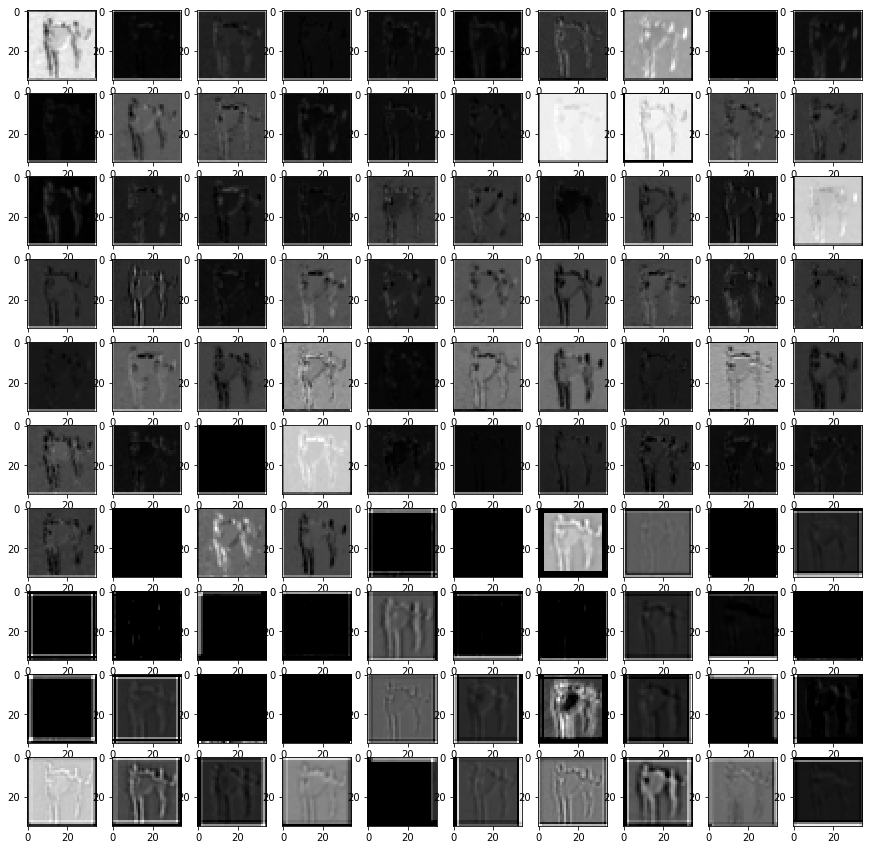

In [15]:
plt.rcParams['figure.figsize'] = (15, 15)        # size of images
plt.rcParams['image.cmap'] = 'gray'              # use grayscale 
fig = plt.figure()
n=0
for i in range(100): #Print the first 100 outputs of the 256.
    n += 1
    a = fig.add_subplot(10,10,n)
    plt.imshow(mixed0_features[0,:,:,i])


In [16]:
#Extract the first convolutional weights
conv2d_1_w = model2.get_layer(base_model.layers[1].name).get_weights()[0]
conv2d_1_w.shape

(3, 3, 3, 32)

# Fine tuning of the last layers
    - We will freeze the bottom N layers and train the remaining top layers.

In [17]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)



0 input_2
1 conv2d_95
2 batch_normalization_95
3 activation_95
4 conv2d_96
5 batch_normalization_96
6 activation_96
7 conv2d_97
8 batch_normalization_97
9 activation_97
10 max_pooling2d_5
11 conv2d_98
12 batch_normalization_98
13 activation_98
14 conv2d_99
15 batch_normalization_99
16 activation_99
17 max_pooling2d_6
18 conv2d_103
19 batch_normalization_103
20 activation_103
21 conv2d_101
22 conv2d_104
23 batch_normalization_101
24 batch_normalization_104
25 activation_101
26 activation_104
27 average_pooling2d_10
28 conv2d_100
29 conv2d_102
30 conv2d_105
31 conv2d_106
32 batch_normalization_100
33 batch_normalization_102
34 batch_normalization_105
35 batch_normalization_106
36 activation_100
37 activation_102
38 activation_105
39 activation_106
40 mixed0
41 conv2d_110
42 batch_normalization_110
43 activation_110
44 conv2d_108
45 conv2d_111
46 batch_normalization_108
47 batch_normalization_111
48 activation_108
49 activation_111
50 average_pooling2d_11
51 conv2d_107
52 conv2d_109
53 co

In [18]:
# we chose to train the top 2 inception blocks, i.e. we will freeze from the mixed8 layer
# Then, freeze the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True



In [19]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
opt = optimizers.SGD(lr=0.0001, momentum=0.9)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history2 = model.fit_generator(datagen.flow(X_train, y_train),
            steps_per_epoch = train_size // batch_size,
            epochs = 10,
            validation_data = (X_valid, y_valid),
            callbacks=[tb_callback_ln])



Epoch 1/10
43/43 [==============================] - 32s - loss: 0.0797 - acc: 0.9680 - val_loss: 0.0618 - val_acc: 0.9733
Epoch 2/10
43/43 [==============================] - 31s - loss: 0.0732 - acc: 0.9753 - val_loss: 0.0607 - val_acc: 0.9750
Epoch 3/10
43/43 [==============================] - 31s - loss: 0.0663 - acc: 0.9799 - val_loss: 0.0593 - val_acc: 0.9767
Epoch 4/10
43/43 [==============================] - 31s - loss: 0.0458 - acc: 0.9862 - val_loss: 0.0586 - val_acc: 0.9767
Epoch 5/10
43/43 [==============================] - 31s - loss: 0.0576 - acc: 0.9830 - val_loss: 0.0578 - val_acc: 0.9767
Epoch 6/10
43/43 [==============================] - 31s - loss: 0.0576 - acc: 0.9826 - val_loss: 0.0574 - val_acc: 0.9733
Epoch 7/10
43/43 [==============================] - 31s - loss: 0.0593 - acc: 0.9833 - val_loss: 0.0573 - val_acc: 0.9733
Epoch 8/10
43/43 [==============================] - 31s - loss: 0.0599 - acc: 0.9801 - val_loss: 0.0563 - val_acc: 0.9733
Epoch 9/10
43/43 [======

## Evaluate the test data

In [ ]:
test_filelist = [f for f in listdir(join(data_path, 'test')) if isfile(join(data_path, 'test', f))]
len(test_filelist)

In [ ]:
image_array = []
real_test = []
for f in test_filelist:
    real_test += [f.split('.')[0]]
    img_path = join(data_path, 'test', f)
    img = load_image(img_path, draw=False)
    image_array += list(img)
    
probability_test = model.predict(np.array(image_array))
probability_test.shape


In [ ]:
print(len(real_test))
clasify_test = np.argmax(predict_test, axis=0)
predict_test = [labels[np.argmax(p)] for p in probability_test ]
print(len(predict_test))

In [ ]:
# Print errors
errors_index=[]
for i in range(len(real_test)):
    if real_test[i]!=predict_test[i]:
        errors_index += [i]
    
print('Pct errors test: ', len(errors_index)/len(predict_test))

fig = plt.figure()
n=0
for i in errors_index[:25]: 
    n += 1
    a = fig.add_subplot(5, 5, n)
    img_path = join(data_path, 'test', test_filelist[i])
    a.set_title('P:' + predict_test[i])
    plt.imshow(plt.imread(img_path))
